# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Дерево решений


**Общая информация**

**Срок сдачи:** до 1 ноября 2018, 06:00 
**Штраф за опоздание:** -2 балла после 06:00 1 ноября, -4 балла после 06:00 8 ноября, -6 баллов после 06:00 15 ноября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw2.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (4 балла)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. В комментариях, где написано "Что делает этот блок кода?", ответьте на этот вопрос. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на wine и Speed Dating Data.

###### Задание 2 (2 балла)
Добиться скорости работы fit такой, чтобы она была медленнее sklearn не более чем в 10 раз. Скорость проверяем на  wine и Speed Dating Data. Для ускорения используем только numpy.

###### Задание 3 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 3 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 4 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from math import sqrt

%matplotlib inline
%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None,
                 sufficient_share=1.0, criterion='gini',
                 max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
            self.imp_check_func = self.__gini_gain
        elif criterion == 'entropy':
            self.G_function = self.__entropy
            self.imp_check_func = self.__entropy_gain
        elif criterion == 'misclass':
            self.G_function = self.__misclass
            self.imp_check_func = self.__misclass_gain
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features is None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return 1 - (np.sum(l_c ** 2 / l_s, axis=1) +
                    np.sum(r_c ** 2 / r_s, axis=1)) / (l_s[0] + r_s[0])

    def __gini_gain(self, c_c, c_s, ch_impur):
        return 1 - np.sum((c_c / float(c_s)) ** 2) - ch_impur

    def __entropy(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        # 0 * log2(0) ambivalence correction to 0 * log2(1)
        lp_c = l_c / l_s
        lp_c[lp_c == 0] = 1
        rp_c = r_c / r_s
        rp_c[rp_c == 0] = 1
        return -(np.sum(l_c * np.log2(lp_c), axis=1) +
                 np.sum(r_c * np.log2(rp_c), axis=1)) / (l_s[0] + r_s[0])

    def __entropy_gain(self, c_c, c_s, ch_impur):
        # 0 * log2(0) ambivalence correction to 0 * log2(1)
        cp_c = c_c / float(c_s)
        cp_c[cp_c == 0] = 1
        return - np.sum(c_c * np.log2(cp_c)) / float(c_s) - ch_impur

    def __misclass(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return 1 - (l_c.max(axis=1) + r_c.max(axis=1)) / (l_s[0] + r_s[0])

    def __misclass_gain(self, c_c, c_s, ch_impur):
        return c_c.max() / float(c_s) - ch_impur

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = list(range(n_feature))
        np.random.shuffle(feature_ids)
        return feature_ids[:int(sqrt(n_feature))]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = list(range(n_feature))
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.log2(n_feature))]

    def __get_feature_ids_N(self, n_feature):
        return np.arange(n_feature)

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        # Сортировка признаков по возрастанию,
        # применение соответствующей перестановки к вектору ответов
        sorted_x, sorted_y = self.__sort_samples(x, y)
        class_number = self.num_class
        cut_size = np.int(self.min_samples_split / 2 - 1)

        # Обрезание краёв вектора ответов; поиск индексов элементов
        # изначального вектора ответов, в которых происходит смена класса
        if cut_size == 0:
            splitted_sorted_y = sorted_y
        else:
            splitted_sorted_y = sorted_y[cut_size:-cut_size]
        r_border_ids = np.where(splitted_sorted_y[:-1] !=
                                splitted_sorted_y[1:])[0] + (cut_size + 1)

        if len(r_border_ids) == 0:
            return np.inf, None

        # Подсчёт элементов между границами смен класса
        eq_el_count = r_border_ids - np.append(np.array([cut_size]),
                                               r_border_ids[:-1])
        one_hot_code = np.zeros((r_border_ids.shape[0], class_number))
        one_hot_code[np.arange(r_border_ids.shape[0]),
                     sorted_y[r_border_ids - 1]] = 1
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + \
            np.bincount(sorted_y[:cut_size], minlength=class_number)

        # Формирование различных разбиений
        l_class_count = np.cumsum(class_increments, axis=0)
        r_class_count = np.bincount(sorted_y,
                                    minlength=class_number) - l_class_count
        l_sizes = r_border_ids.reshape(l_class_count.shape[0], 1)
        r_sizes = sorted_y.shape[0] - l_sizes

        # Выбор разбиения с наименьшим impurity
        gs = self.G_function(l_class_count, l_sizes, r_class_count, r_sizes)
        idx = np.argmin(gs)

        # Возвращает пару impurity, threshold
        # для разбиения с наименьшим impurity
        left_el_id = l_sizes[idx][0]
        return gs[idx], (sorted_x[left_el_id-1] + sorted_x[left_el_id]) / 2.0

    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        class_count = np.bincount(y)
        class_max = class_count.argmax()
        if depth == self.max_depth or y.size <= self.min_samples_split or \
                class_count.max() >= y.size * self.sufficient_share:

            self.tree[node_id] = [self.LEAF_TYPE, class_max,
                                  class_count.astype(float) / y.size]
            return

        features = self.get_feature_ids(x.shape[1])
        min_impure = np.Inf
        min_thresh = None
        min_ind = None
        for i in features:
            impur, thresh = self.__find_threshold(x[:, i], y)
            if (impur < min_impure):
                min_impure = impur
                min_thresh = thresh
                min_ind = i

        feature = min_ind
        threshold = min_thresh
        if threshold is None:
            self.tree[node_id] = [self.LEAF_TYPE, class_max,
                                  class_count.astype(float) / y.size]
            return

        gain = self.imp_check_func(class_count, np.sum(class_count), impur)
        self.feature_importances_[feature] += gain
        x_l, x_r, y_l, y_r = self.__div_samples(x, y, feature, threshold)

        if x_l.size is 0 or y_l.size is 0:
            self.tree[node_id] = [self.LEAF_TYPE, class_max,
                                  class_count.astype(float) / y.size]
            return

        self.tree[node_id] = [self.NON_LEAF_TYPE, feature, threshold]
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1, pred_f)
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1, pred_f)

    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ /= self.feature_importances_.sum()

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, 
                                        wine.target, test_size=0.1, stratify=wine.target)

## Проверка скорости работы на wine

In [5]:
%time clf.fit(X_train, y_train)

CPU times: user 3.12 ms, sys: 0 ns, total: 3.12 ms
Wall time: 2.19 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [6]:
%time my_clf.fit(X_train, y_train)

CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 13.6 ms


## Проверка качества работы на wine

In [7]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.8916666666666667

In [8]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.8916666666666667

## Подготовка данных Speed Dating Data 

In [47]:
#%%pycodestyle

df = pd.read_csv('speed-dating-experiment/Speed Dating Data.csv',
                 encoding='cp1251')
df = df.iloc[:, :97]
df.iid.nunique()
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df.drop_duplicates(subset=['iid']).gender.value_counts()
df.drop_duplicates(subset=['iid']).condtn.value_counts()
df = df.drop(['condtn'], axis=1)
df.wave.unique()
df = df.drop(['round'], axis=1)
df = df.drop(['position', 'positin1'], axis=1)
df = df.drop(['order'], axis=1)
df = df.drop(['partner'], axis=1)
df = df.drop(['age_o', 'race_o', 'pf_o_att',
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o'],
             axis=1)
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(0)
df = df.drop(['field'], axis=1)
df = df.drop(['undergra'], axis=1)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)
df.loc[:, 'tuition'] = \
        df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.tuition.fillna(-999)
df = df.dropna(subset=['imprelig', 'imprace'])
df = df.drop(['from', 'zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)
df.loc[:, 'date'].isnull().sum()
df = df.dropna(subset=['date'])
df.career_c.isnull().sum()
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(0)
df = df.drop(['career'], axis=1)
df.loc[:, ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art',
           'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
           'movies', 'concerts', 'music', 'shopping', 'yoga']].isnull().sum()
df = df.drop(['sports', 'tvsports', 'exercise', 'dining', 'museums',
              'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
              'theater', 'movies', 'concerts', 'music',
              'shopping', 'yoga'], axis=1)
df = df.drop(['expnum'], axis=1)
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1',
        'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.head()
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
temp.head()
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ].head()
df.loc[:, 'temp_totalsum'] = \
    df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
               'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
           'fun1_1', 'amb1_1', 'shar1_1']] = \
        (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1',
                    'fun1_1', 'amb1_1', 'shar1_1']].T /
         df.loc[:, 'temp_totalsum'].T).T * 100
df.head()
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1',
        'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) \
    & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
df.loc[:, 'temp_totalsum'] = \
    df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
               'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
           'fun2_1', 'amb2_1', 'shar2_1']] = \
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1',
                'fun2_1', 'amb2_1', 'shar2_1']].T /
     df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)

for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]

    if i != 4:
        feat.remove('shar{}_1'.format(i))

    df = df.drop(feat, axis=1)

df = df.drop(['wave'], axis=1)
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid']) \
    .drop(['gender'], axis=1).dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid']) \
    .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1).dropna()

df_female.columns = df_female.columns + '_f'
df_male.head()
df_female = df_female.drop(['pid_f'], axis=1)
df_female.head()
df_pair = df_male.join(df_female.set_index('iid_f'),
                       on='pid',
                       how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)
X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values
features = df_pair.columns[1:]


In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [121]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

## Проверка скорости работы на Speed Dating Data 

In [122]:
%time clf.fit(X_train, y_train)

CPU times: user 97.4 ms, sys: 79 µs, total: 97.4 ms
Wall time: 96.9 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [123]:
%time my_clf.fit(X_train, y_train)

CPU times: user 858 ms, sys: 3.5 ms, total: 862 ms
Wall time: 861 ms


## Проверка качества работы на Speed Dating Data

In [124]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.5355705605843695

In [125]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.5383813565631748

## Задание 3

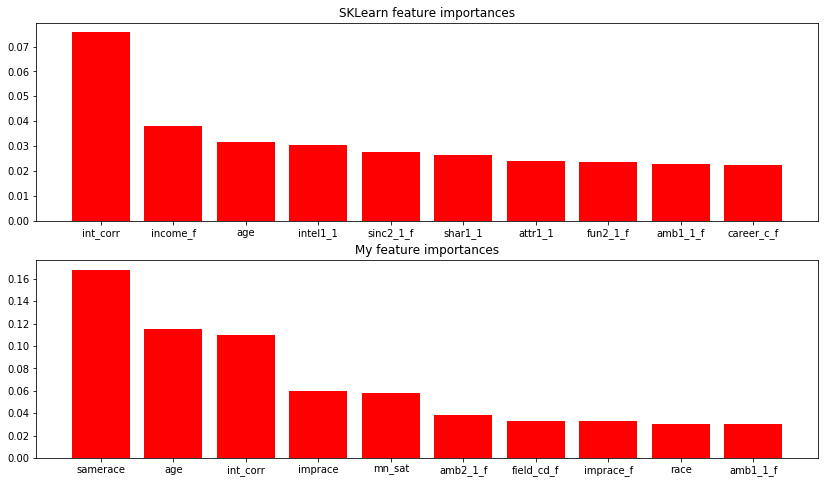

In [126]:
fig = plt.figure(figsize=(14, 8))

ax1 = fig.add_subplot(211)
importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]
indices = indices[::-1]

plt.title("SKLearn feature importances")
plt.bar(range(len(indices)), importances[indices],
       color="r", align="center")
plt.xticks(range(len(indices)), features[indices])


ах2 = fig.add_subplot(212)

my_importances = my_clf.feature_importances_
my_indices = np.argsort(my_importances)[-10:]
my_indices = my_indices[::-1]


plt.title("My feature importances")
plt.bar(range(len(my_indices)), my_importances[my_indices],
       color="r", align="center")
plt.xticks(range(len(my_indices)), features[my_indices])
plt.show()

## Задание 4

In [127]:
parameters = {'criterion': ('gini', 'entropy'), 
              'min_samples_leaf': list(range(1, 11)),
              'n_estimators': list(range(10, 110, 10))}

In [128]:
clf = RandomForestClassifier()
grid = GridSearchCV(clf, parameters, cv=5)

In [129]:
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ('gini', 'entropy'), 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [130]:
grid.best_params_

{'criterion': 'gini', 'min_samples_leaf': 5, 'n_estimators': 50}